# **Important Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Dataset

In [2]:
def create_dataset(data_dir):
  filepaths = []
  labels = []
  folds = os.listdir(data_dir)
  for fold in folds:
    foldpath = os.path.join(data_dir,fold)
    fileslist = os.listdir(foldpath)
    for file in fileslist:
      filepath = os.path.join(foldpath, file)
      filepaths.append(filepath)
      labels.append(fold)
  return pd.DataFrame({"files":filepaths,"labels":labels})

In [3]:
DATA_DIR = "/kaggle/input/shoplifting-videos-dataset/Shop DataSet"

df = create_dataset(DATA_DIR)
df.head()

,files,labels
0,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters
1,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters
2,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters
3,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters
4,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters


In [4]:
df.labels.value_counts()

labels
non shop lifters    531
shop lifters        324
Name: count, dtype: int64

In [5]:
MIN_FRAMES = 16
def is_long_enough(path, min_frames=MIN_FRAMES):
    cap = cv2.VideoCapture(path)
    ok = cap.isOpened()
    if not ok:
        cap.release()
        return False
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return n >= min_frames

mask = df['files'].apply(is_long_enough)
df = df[mask].reset_index(drop=True)
print(f"Kept {len(df)} / {len(df)} videos (≥{MIN_FRAMES} frames)")

Kept 855 / 855 videos (≥16 frames)


In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
valid_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

print("Train/Val/Test sizes:", train_df.shape[0], valid_df.shape[0], test_df.shape[0])

Train/Val/Test sizes: 684 85 86


# **Dataset Preprocessing**

In [7]:
# Custom Dataset for video data
class VideoDataset(Dataset):
    def __init__(self, dataframe, frames_per_video=16, frame_size=(64, 64)):
        self.df = dataframe.reset_index(drop=True)
        self.frames_per_video = frames_per_video
        self.frame_size = frame_size
        self.le = LabelEncoder()
        self.labels = self.le.fit_transform(self.df['labels'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['files']
        label = self.labels[idx]

        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(total_frames // self.frames_per_video, 1)

        frames = []
        for i in range(self.frames_per_video):
            frame_idx = min(i * step, total_frames - 1)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, self.frame_size)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
                frame = np.transpose(frame, (2, 0, 1))          # C,H,W
                frames.append(frame)
            else:
                # duplicate last valid frame if read fails
                frames.append(frames[-1] if frames else np.zeros((3, *self.frame_size)))
        cap.release()

        frames = np.stack(frames, axis=0)          # T,C,H,W
        return torch.tensor(frames, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [8]:
# Create datasets and dataloaders
train_ds = VideoDataset(train_df)
val_ds   = VideoDataset(valid_df)
test_ds  = VideoDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False)

# **Model**

In [9]:
# CNN-LSTM Model
class VideoClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # After 3×MaxPool2d on 64×64 → 8×8
        self.lstm = nn.LSTM(input_size=128*8*8, hidden_size=256, batch_first=True)
        self.fc   = nn.Sequential(nn.Dropout(0.5),
                                  nn.Linear(256, num_classes))

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.reshape(b * t, c, h, w)
        x = self.cnn(x)
        x = x.reshape(b, t, -1)
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

# Initialize model
model = VideoClassificationModel(num_classes=len(train_ds.le.classes_)).to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=1e-3)

num_epochs = 15
best_val_loss = np.inf
patience, patience_max = 0, 5

for epoch in range(1, num_epochs+1):

    model.train()
    running_loss = 0.0
    for vids, labs in tqdm(train_loader, leave=False):
        vids, labs = vids.to(device, non_blocking=True), labs.to(device, non_blocking=True)
        optimizer.zero_grad()
        logits = model(vids)
        loss = criterion(logits, labs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * vids.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for vids, labs in val_loader:
            vids, labs = vids.to(device, non_blocking=True), labs.to(device, non_blocking=True)
            logits = model(vids)
            loss = criterion(logits, labs)
            running_loss += loss.item() * vids.size(0)
    val_loss = running_loss / len(val_loader.dataset)

    print(f"Epoch {epoch} | Train loss {train_loss:.4f} | Val loss {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), 'video_classification.pt')
    else:
        patience += 1
        if patience >= patience_max:
            print("Early stopping")
            break

Epoch 1 | Train loss 0.6767 | Val loss 0.6587


Epoch 2 | Train loss 0.6571 | Val loss 0.6500


Epoch 3 | Train loss 0.5170 | Val loss 0.2094


Epoch 4 | Train loss 0.2686 | Val loss 0.1754


Epoch 5 | Train loss 0.1950 | Val loss 0.1436


Epoch 6 | Train loss 0.1885 | Val loss 0.1460


Epoch 7 | Train loss 0.0808 | Val loss 0.0072


Epoch 8 | Train loss 0.0220 | Val loss 0.0888


Epoch 9 | Train loss 0.0204 | Val loss 0.0041


Epoch 10 | Train loss 0.0028 | Val loss 0.0011


Epoch 11 | Train loss 0.0008 | Val loss 0.0003


Epoch 12 | Train loss 0.0121 | Val loss 0.4302


Epoch 13 | Train loss 0.2037 | Val loss 0.0021


Epoch 14 | Train loss 0.0020 | Val loss 0.0013


Epoch 15 | Train loss 0.0013 | Val loss 0.0009


# **Evaluation**

In [11]:
model.load_state_dict(torch.load('video_classification.pt'))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for vids, labs in test_loader:
        vids, labs = vids.to(device), labs.to(device)
        logits = model(vids)
        preds = logits.argmax(1)
        y_true.extend(labs.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=test_ds.le.classes_))

                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00        53
    shop lifters       1.00      1.00      1.00        33

        accuracy                           1.00        86
       macro avg       1.00      1.00      1.00        86
    weighted avg       1.00      1.00      1.00        86



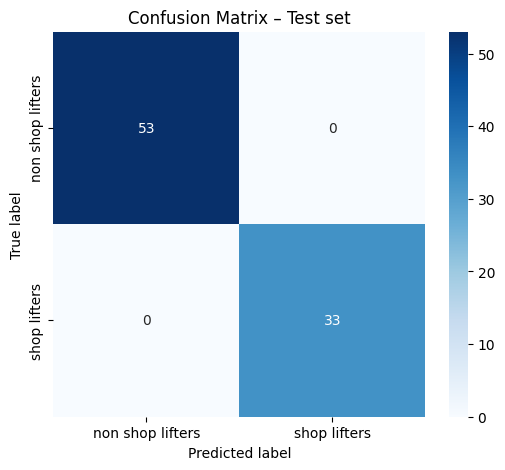

In [12]:
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(test_ds.le.classes_)))

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=test_ds.le.classes_,
            yticklabels=test_ds.le.classes_)
plt.title('Confusion Matrix – Test set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()